# Algorithm 1 - Logistic Regression Classifier

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.getcwd(), 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features import process_features
from features.process_features import get_vif, standardize

ALGORITHM_NAME = 'lr'
COUNTRY = 'riau'
TRAIN_PATH, TEST_PATH = get_country_filepaths(COUNTRY)

In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.miskin.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 6,136 rows and 506 columns
Percent poor: 4.9% 	Percent non-poor: 95.1%


,r105,r1701,r1702,r1703,r1704,r1705,r1706,r1707,r1708,r1801,...,kons_307,kons_308,kons_309,kons_310,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nbekerja,der_ninternetpast3mo
0,1,5,5,5,5,5,5,5,5,0,...,0,0,0,0,0,0,1,1,0,1
1,2,5,5,5,5,5,5,5,5,1,...,0,0,0,0,0,3,1,4,1,2
2,1,5,5,5,5,5,5,5,5,1,...,0,0,0,0,0,3,2,5,1,5
3,2,5,5,5,5,5,5,5,5,1,...,0,0,0,0,1,3,2,5,2,1
4,2,5,5,5,5,5,5,5,5,1,...,0,0,0,0,0,1,1,2,1,0


## Unbalanced vs Balanced Datasets 

Class labels in the Riau data are unbalanced. This means that there are much fewer examples of "poor" households (~6%) than "non-poor" (~94%). If we were only using classification accuracy as a metric (The number of correct predictions), this means that we could simply predict that every household is non-poor and have a model with ~94% accuracy! However, this would obviously not help us reach our goals for actually understanding and predicting poverty in Riau.

As a quick demonstration of this, let's simulate a dummy classifier that predicts '0' with a 50% probability for everything:

C:\ProgramData\Anaconda3\envs\satudata\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


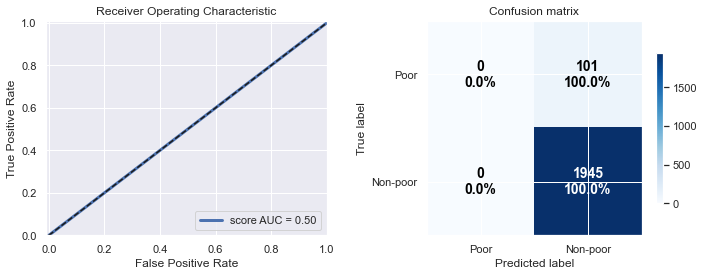

,score
accuracy,0.950635
recall,0.000000
precision,0.000000
f1,0.000000
cross_entropy,0.693147
roc_auc,0.500000
cohen_kappa,0.000000


In [3]:
# Load the test set
X_test, y_test, w_test = split_features_labels_weights(TEST_PATH)

# Predict everything as 'non-poor', with 50% probability
y_pred = np.zeros(len(y_test))
y_prob = np.ones(len(y_test)) * 0.5

# Evaluate performance
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, show=True)

As we predicted, the classifier gives us an accuracy of ~95%, but we can see pretty clearly from the other metrics that it is not performing well. This is one reason why accuracy is not the only metric we use to evaluate the performance of a model. In the case of poverty prediction, we may be more concerned with having a high recall, which in this case is the fraction of 'poor' households we predict correctly as 'poor' over the total number of actual 'poor' households.

Now let's see how an actual LogisticRegression classifier is affected by unbalanced data. We'll start with a small dataset of just a few features and see if the same multicollinearity issues exist.

## Dummy variables
Another consideration is the creation of dummy variables. Some classification algorithms are able to handle categorical variables easily, but others require the inputs to be numeric. When we have categorical variables, the preffered method is to create dummy variables. This takes the categorical feature and creates a new binary column for each value. We can also include a dummy to deal with missing values. We don't necessarily want a dummy for every column, though. If we have n columns from n categories, every column is actually a linear combination of the other columns, creating a multicollinearity problem known as the dummy variable trap. To deal with this issue, we drop the first dummy variable for each categorical variable. Pandas has a nice function called get_dummies() that makes this process simple.

We will also want to remove features that are not useful for a classification problem, such as empty or constant columns and duplicate columns.

In [4]:
X_train = pd.get_dummies(X_train, drop_first=True, dummy_na=True, prefix_sep='__')
X_test = pd.get_dummies(X_test, drop_first=True, dummy_na=True, prefix_sep='__')

print("X_train shape with dummy variables added", X_train.shape)
print("X_test shape with dummy variables added", X_test.shape)

X_train shape with dummy variables added (6136, 506)
X_test shape with dummy variables added (2046, 506)


In [5]:
# remove columns with only one unique value (all nan dummies from columns with no missing values)

X_train = X_train.loc[:, X_train.nunique(axis=0) > 1]
X_test = X_test.loc[:, X_test.nunique(axis=0) > 1]

print("X_train shape with constant columns dropped", X_train.shape)
print("X_test shape with constant columns dropped", X_test.shape)

X_train shape with constant columns dropped (6136, 503)
X_test shape with constant columns dropped (2046, 503)


In [6]:
# remove duplicate columns - these end up being all from nan or Not Applicable dummies 

process_features.drop_duplicate_columns(X_train, ignore=['fwt', 'weind'], inplace=True)
process_features.drop_duplicate_columns(X_test, ignore=['fwt', 'weind'], inplace=True)

print("X_train shape with duplicate columns dropped", X_train.shape)
print("X_test shape with duplicate columns dropped", X_test.shape)

X_train shape with duplicate columns dropped (6136, 497)
X_test shape with duplicate columns dropped (2046, 500)


In [7]:
# X_train.to_csv("X_train_with_dummy.csv", index=False, header=True)

## Simple Model

In [8]:
# Select a few columns for this example
selected_columns = [
    'r301', 
    'der_nchild10under', 
    'der_nmalesover10', 
    'der_nfemalesover10',
    'der_nliterate', 
    'der_nbekerja',
    'r1809a',
    'r1816',
    'kons_305',
    'kons_262'
]

print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (6136, 10)


In [9]:
get_vif(X_train[selected_columns])

C:\ProgramData\Anaconda3\envs\satudata\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


r301                        inf
der_nchild10under           inf
der_nmalesover10            inf
der_nfemalesover10          inf
der_nliterate         68.733254
der_nbekerja           6.218668
r1809a                 2.331949
r1816                  3.485068
kons_305               1.041615
kons_262               1.027109
Name: variance_inflaction_factor, dtype: float64

Several of these VIF results are very high, so let's standardize the numeric data and check again.

In [10]:
standardize(X_train)
get_vif(X_train[selected_columns])

C:\ProgramData\Anaconda3\envs\satudata\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


r301                        inf
der_nchild10under           inf
der_nmalesover10            inf
der_nfemalesover10          inf
der_nliterate         10.376394
der_nbekerja           1.443363
r1809a                 1.034608
r1816                  1.036954
kons_305               1.013604
kons_262               1.003865
Name: variance_inflaction_factor, dtype: float64

These VIF results are still very high, so once again let's remove the r301 (household size) feature

In [11]:
selected_columns.remove('r301')
print(selected_columns)

get_vif(X_train[selected_columns])

['der_nchild10under', 'der_nmalesover10', 'der_nfemalesover10', 'der_nliterate', 'der_nbekerja', 'r1809a', 'r1816', 'kons_305', 'kons_262']


der_nchild10under      1.652763
der_nmalesover10       5.557242
der_nfemalesover10     4.588654
der_nliterate         10.376394
der_nbekerja           1.443363
r1809a                 1.034608
r1816                  1.036954
kons_305               1.013604
kons_262               1.003865
Name: variance_inflaction_factor, dtype: float64

Now the VIF results are back in an acceptable range, so let's use these features and train a LogisticRegression model. We can use the load_data function in the load_data.py module, which uses our standardize function by default.

We'll also store these selected features in RIAU_SIMPLE_FEATURES so we can use the same subset in other notebooks.

In [12]:
# Same method for getting the coefficients
def get_coefs_df(X, coefs, index=None):
    coefs_df = pd.DataFrame(np.std(X, 0)*coefs)
    coefs_df.columns = ["coef_std"]
    coefs_df['coef'] = coefs
    coefs_df['abs'] = coefs_df.coef_std.apply(abs)
    if index is not None:
        coefs_df.index = index
    return coefs_df

Wall time: 14 ms
Wall time: 999 µs
In-sample score: 95.06%


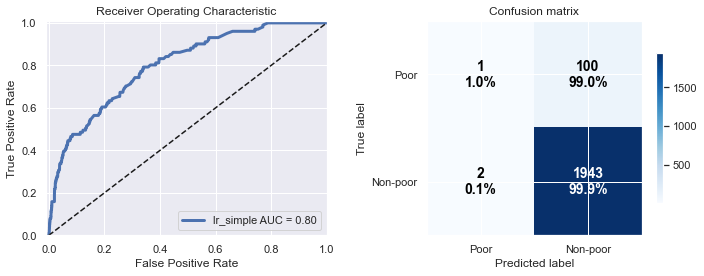

,lr_simple
accuracy,0.950147
recall,0.009901
precision,0.333333
f1,0.019231
cross_entropy,0.164615
roc_auc,0.799743
cohen_kappa,0.016430


Actual poverty rate: 6.82% 
Predicted poverty rate: 0.83% 


In [13]:
from sklearn.linear_model import LogisticRegression

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=selected_columns)

# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train, model.coef_[0])

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

Here we see that the recall is only ~1%, which means we do a very poor job of predicting that poor households are poor. This is probably due to the fact that we have so few examples of poor households to train the model on. An interesting metric to consider is the Cohen's Kappa metric. This normalizes the classification accuracy by the imbalance of the classes in the data. Here we can see it is only ~1,6%.

## Class Weighting
Scikit-Learn offers several methods to deal with unbalanced classes. One is to adjust the weights of the classes to be inversely proportional to the class frequencies. This can be a simple way to increase the recall of the model, but usually has a negative effect on the accuracy and precision.

Wall time: 13 ms
Wall time: 2 ms
In-sample score: 73.19%


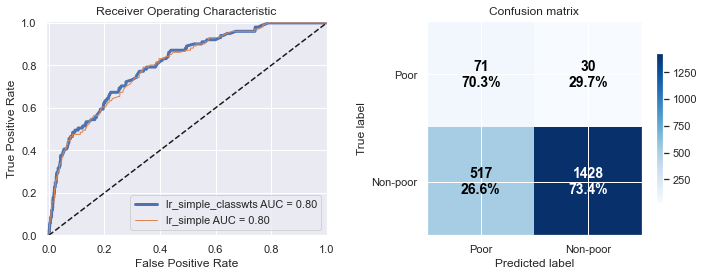

,lr_simple_classwts,lr_simple
accuracy,0.732649,0.950147
recall,0.702970,0.009901
precision,0.120748,0.333333
f1,0.206096,0.019231
cross_entropy,0.537430,0.164615
roc_auc,0.804167,0.799743
cohen_kappa,0.133050,0.016430


Actual poverty rate: 6.82% 
Predicted poverty rate: 41.00% 


In [14]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=selected_columns)

# Fit the model using class_weight='balanced' 
model = LogisticRegression(class_weight='balanced')
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train[selected_columns], model.coef_[0])

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models='lr_simple',
                                    store_model=True,
                                    model_name='simple_classwts',
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

This did not change the AUC much, but it made a significant improvement to the model's recall, bringing it up to about 70%.

Now let's try doing this with the full feature set with sample weights and see the effects:

C:\ProgramData\Anaconda3\envs\satudata\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wall time: 290 ms
Wall time: 16 ms
In-sample score: 99.91%


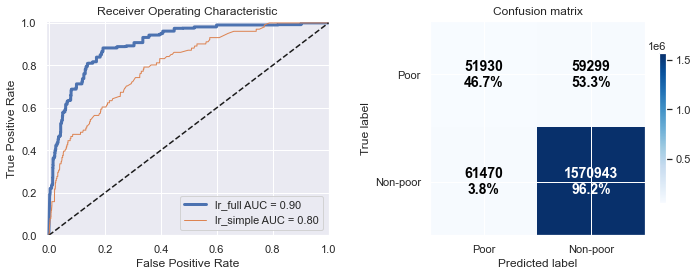

,lr_full,lr_simple
accuracy,0.930738,0.950147
recall,0.466875,0.009901
precision,0.457938,0.333333
f1,0.462363,0.019231
cross_entropy,1.327124,0.164615
roc_auc,0.904081,0.799743
cohen_kappa,0.363980,0.016430


Actual poverty rate: 6.82% 
Predicted poverty rate: 6.86% 


In [15]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])['abs']

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_simple',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

This is much better than with the smaller feature set, but we still only have a recall of ~46.7%, which is not very good. Let's try using the balanced class_weights and see how it improves

C:\ProgramData\Anaconda3\envs\satudata\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wall time: 286 ms
Wall time: 16 ms
In-sample score: 99.78%


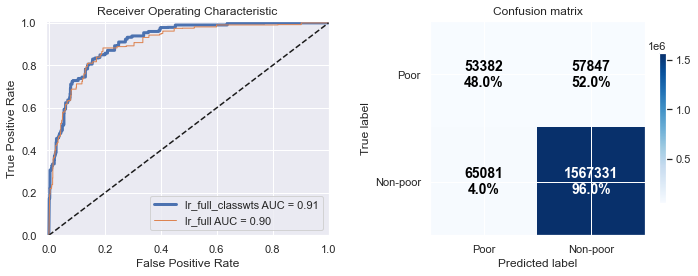

,lr_full_classwts,lr_full
accuracy,0.929499,0.930738
recall,0.479928,0.466875
precision,0.450620,0.457938
f1,0.464812,0.462363
cross_entropy,1.082523,1.327124
roc_auc,0.914168,0.904081
cohen_kappa,0.400154,0.363980


Actual poverty rate: 6.82% 
Predicted poverty rate: 7.29% 


In [16]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model with class_weight='balanced'
model = LogisticRegression(class_weight='balanced')
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])['abs']

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full_classwts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

## Oversampling and Undersampling

Oversampling and Undersampling
Another method is to resample the dataset so the classes are balanced. This can be done by either oversampling or undersampling. With oversampling, we randomly replicate samples of the under-represented class. This is typically the preferred method when the dataset is rather small, on the order of a few thousand records. Undersampling reduces the size of the dataset by sampling the over-represented class. This is a prefereable method when the dataset is very large, since reducing the size of the training set can also reduce the computational cost.

The Riau dataset contains about 8,182 records, with only 6.82% being in the 'poor' class. If we use undersampling, this will reduce our training set to ~ records. If we use oversampling, we will increase the size of the dataset to about ~ records. We will try both approaches here and see which offers better performance.

Fortunately, there is a Python package called imbalanced-learn that provides implementations of several popular oversampling and undersampling techniques and is compatible with scikit-learn.

### Undersampling

We'll apply undersampling using the RandomUnderSampler function from imbalanced-learn. This randomly takes samples the majority class to match the number of records from the under-represented class (or to reach a desired class ratio).

As a note, the imblearn functions return an array rather than a dataframe, so we'll need to store the column names if we want to inspect features or coefficients later.

X shape after undersampling:  (602, 506)
Wall time: 33 ms
Wall time: 6 ms
In-sample score: 100.00%


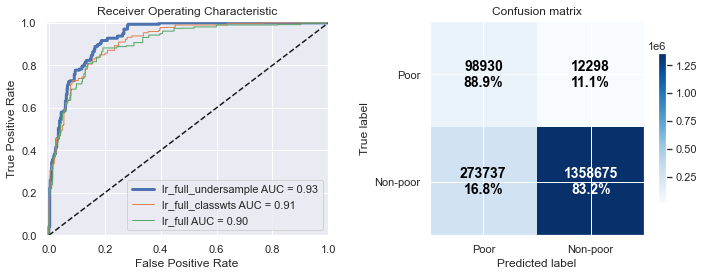

,lr_full_undersample,lr_full_classwts,lr_full
accuracy,0.835955,0.929499,0.930738
recall,0.889434,0.479928,0.466875
precision,0.265465,0.450620,0.457938
f1,0.408891,0.464812,0.462363
cross_entropy,0.634811,1.082523,1.327124
roc_auc,0.933625,0.914168,0.904081
cohen_kappa,0.320408,0.400154,0.363980


Actual poverty rate: 6.82% 
Predicted poverty rate: 22.27% 


In [17]:
from imblearn.under_sampling import RandomUnderSampler

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train, model.coef_[0], index=cols)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_classwts', 
                                                    'lr_full'],
                                    store_model=True,
                                    model_name='full_undersample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

This gives us a slightly better recall than using class weights. It's also considerably faster, since it reduces the size of the training set to less than 10,000 records.

### Oversampling

Next, we'll apply oversampling. One of the most popular oversampling methods is called SMOTE, or Synthetic Minority Oversampling Technique. This works by creating synthetic samples of the under-represented class by finding nearest neighbors and making minor random perturbations.

X shape after oversampling:  (11670, 506)


C:\ProgramData\Anaconda3\envs\satudata\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wall time: 519 ms
Wall time: 28 ms
In-sample score: 99.18%


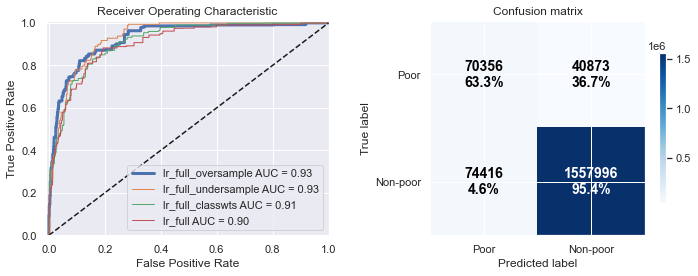

,lr_full_oversample,lr_full_undersample,lr_full_classwts,lr_full
accuracy,0.933880,0.835955,0.929499,0.930738
recall,0.632532,0.889434,0.479928,0.466875
precision,0.485975,0.265465,0.450620,0.457938
f1,0.549652,0.408891,0.464812,0.462363
cross_entropy,0.364062,0.634811,1.082523,1.327124
roc_auc,0.927669,0.933625,0.914168,0.904081
cohen_kappa,0.452221,0.320408,0.400154,0.363980


Actual poverty rate: 6.82% 
Predicted poverty rate: 8.67% 


In [18]:
from imblearn.over_sampling import SMOTE

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train, model.coef_[0], index=cols)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_undersample', 
                                                    'lr_full_classwts', 
                                                    'lr_full'],
                                    store_model=True,
                                    model_name='full_oversample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

This gives us better results than undersampling and weighted classes, so we will use this method going forward. Note that it increases the size of the training set, but it appears to be more computationally efficient than using class weights.

# Cross Validation and Parameter Tuning 

Now that we have a good method for dealing with the unbalanced dataset, let's also apply cross-validation and some hyperparameter tuning using the LogisticRegressionCV model.

X shape after oversampling:  (11670, 506)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\envs\satudata\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\envs\satudata\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternativ

C:\ProgramData\Anaconda3\envs\satudata\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\envs\satudata\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

C:\ProgramData\Anaconda3\envs\satudata\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.1s finished
C:\ProgramData\Anaconda3\envs\satudata\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver op

Wall time: 17.7 s
Wall time: 28 ms
In-sample score: 98.97%
Best model parameters: C=0.3593813663804626


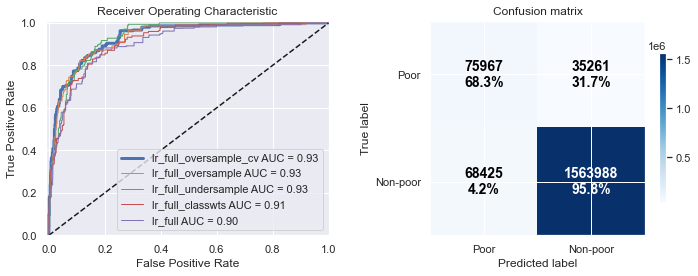

,lr_full_oversample_cv,lr_full_oversample,lr_full_undersample,lr_full_classwts,lr_full
accuracy,0.940535,0.933880,0.835955,0.929499,0.930738
recall,0.682982,0.632532,0.889434,0.479928,0.466875
precision,0.526119,0.485975,0.265465,0.450620,0.457938
f1,0.594375,0.549652,0.408891,0.464812,0.462363
cross_entropy,0.282615,0.364062,0.634811,1.082523,1.327124
roc_auc,0.932446,0.927669,0.933625,0.914168,0.904081
cohen_kappa,0.501967,0.452221,0.320408,0.400154,0.363980


Actual poverty rate: 6.82% 
Predicted poverty rate: 9.01% 


In [19]:
from sklearn.linear_model import LogisticRegressionCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = LogisticRegressionCV(Cs=10, cv=5, verbose=1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0], index=cols)

# Display best parameters
print("Best model parameters: C={}".format(model.C_[0]))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_oversample',
                                                    'lr_full_undersample', 
                                                    'lr_full_classwts',  
                                                    'lr_full'],
                                    store_model=True,
                                    model_name='full_oversample_cv',
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

Using cross-validation and tuning the C parameter is much more computationally expensive to train the model. We may be able to do better by performing more detailed feature selection and fine tuning the model further, but this serves as a decent baseline model for the Riau dataset for this project.

# Feature selection 

let's pick a subset of features using the 'l1' regularization and see how the model performs using only this subset.

In [20]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = LogisticRegressionCV(cv=5, penalty='l1', Cs=[2e-3] , solver='liblinear')
%time model.fit(X_train, y_train)
coefs = get_coefs_df(X_train, model.coef_[0], index=cols)
coefs = coefs[coefs.coef != 0]
print("{} features selected".format(coefs.shape[0]))
display(coefs)
feats = coefs.index.values

X shape after oversampling:  (11670, 506)
Wall time: 1.4 s
27 features selected


,coef_std,coef,abs
r1702,-0.025006,-0.020727,0.025006
r1703,-0.084938,-0.067946,0.084938
r1808,0.049075,0.057586,0.049075
r1817,0.138020,0.109079,0.138020
r2001b,0.287445,0.284924,0.287445
r301,0.702516,0.684113,0.702516
kons_6,-0.020811,-0.024704,0.020811
kons_56,-0.138289,-0.147374,0.138289
kons_68,-0.055540,-0.065937,0.055540
kons_81,-0.018291,-0.021683,0.018291


Now let's see how the model performs with this subset of features

X shape after oversampling:  (11670, 27)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Wall time: 1.11 s
Wall time: 3 ms
In-sample score: 91.00%
Best model parameters: C=0.3593813663804626


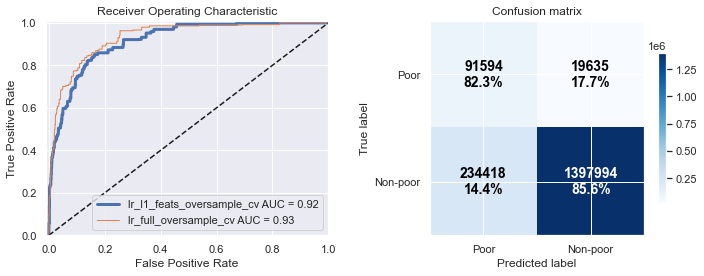

,lr_l1_feats_oversample_cv,lr_full_oversample_cv
accuracy,0.854298,0.940535
recall,0.823472,0.682982
precision,0.280952,0.526119
f1,0.418963,0.594375
cross_entropy,0.364059,0.282615
roc_auc,0.915807,0.932446
cohen_kappa,0.346496,0.501967


Actual poverty rate: 6.82% 
Predicted poverty rate: 19.23% 


In [21]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = LogisticRegressionCV(Cs=10, cv=5, verbose=1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0], index=cols)

# Display best parameters
print("Best model parameters: C={}".format(model.C_[0]))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full_oversample_cv',
                                    store_model=True,
                                    model_name='l1_feats_oversample_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

Using this method, we get slightly worse performance than the full feature model, but we have reduced the number of features to less than 100.

Let's inspect the coefficients for the features we selected and look at the consumable items that remained in the model.

In [22]:
cons_feats = [x for x in feats if x[0:5] == 'kons_']
print("{} consumables features selected:".format(len(cons_feats)))
for x in cons_feats:
    print(x)

19 consumables features selected:
kons_6
kons_56
kons_68
kons_81
kons_107
kons_111
kons_140
kons_160
kons_166
kons_179
kons_193
kons_195
kons_214
kons_224
kons_229
kons_238
kons_268
kons_271
kons_278


# Logistic Regression Riau Summary 

In this notebook, we demonstrated applying a logistic regression classifier to an unbalanced dataset. We introduced methods to deal with unbalanced classes such as SMOTE for oversampling, and highlighted the impact this has on how we evaluate a model.

We will use the results of the logistic regression classifier as a baseline for the other algorithms we will consider. In the following notebooks, we will introduce some new concepts but will primarily focus on the unique characteristics of each classifier model.

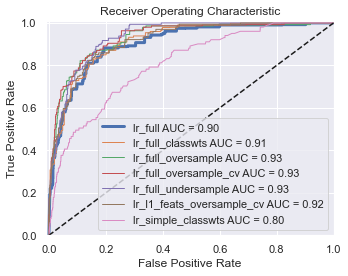

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
lr_full,0.930738,0.466875,0.457938,0.462363,1.327124,0.904081,0.363980,0.000409
lr_full_classwts,0.929499,0.479928,0.450620,0.464812,1.082523,0.914168,0.400154,0.004715
lr_full_oversample,0.933880,0.632532,0.485975,0.549652,0.364062,0.927669,0.452221,0.018465
lr_full_oversample_cv,0.940535,0.682982,0.526119,0.594375,0.282615,0.932446,0.501967,0.021896
lr_full_undersample,0.835955,0.889434,0.265465,0.408891,0.634811,0.933625,0.320408,0.154480
lr_l1_feats_oversample_cv,0.854298,0.823472,0.280952,0.418963,0.364059,0.915807,0.346496,0.124128
lr_simple_classwts,0.732649,0.702970,0.120748,0.206096,0.537430,0.804167,0.133050,0.341761


In [23]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)